**<big>Building the Clustering Model</big>**

The pre-processed data is imported using the pandas library and its contents are viewed before commencing the construction of the model.
The dataframe consists of three features : Item Name, Category Name and Quantity sold (kilo).
The 'Item Name' and 'Category Name' contain categorical data while the 'Quantity Sold (kilo)' column consists of numerical data.  

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/pre_processed_data.csv')

In [3]:
df.head(10)

,item_name,category_name,quantity_sold_kg
0,green hot peppers,capsicum,1.1
1,green hot peppers,capsicum,0.6
2,yunnan lettuces,flower,0.5
3,xixia mushroom,mushroom,0.4
4,paopaojiao,capsicum,0.6
5,red hang pepper,capsicum,0.2
6,xixia mushroom,mushroom,0.2
7,paopaojiao,capsicum,0.4
8,paopaojiao,capsicum,0.3
9,luosi pepper,capsicum,0.4


**Clustering Algorithm and the Optimal number of clusters**

The dataframe consists of both categorical and numerical data, therefore it is good to choose an algorithm that can deal with both these data types. The k-prototypes is a clustering algorithm that performs k-means clustering for the numerical data and k-modes clustering for the categorical data; this algorithm does not require the dataset to be encoded.

Before building the clustering algorithm, the optimal number of clusters must be found.This can be done using the elbow method and the  silhouette method.The number of unique items in the "Category Name" column is checked because there is a likelihood of the optimal number of clusters being close to this number. 


In [4]:
df['category_name'].unique()
#Number of clusters could be close to 6

array(['capsicum', 'flower', 'mushroom', 'aquatic', 'cabbage', 'solanum'],
      dtype=object)

In [5]:
#df_sample =df(frac=0.01, random_state=42)
#df_sample.shape

**<big>i) The Elbow method</big>**

In [6]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

In [7]:
cost = []

for k in range(1,11): #range 1 to 10
    k_proto = KPrototypes(n_clusters = k, init='Cao', max_iter=50, n_jobs=-1, verbose=0)
    k_proto.fit_predict(df, categorical = [0,1])
    cost.append(k_proto.cost_)

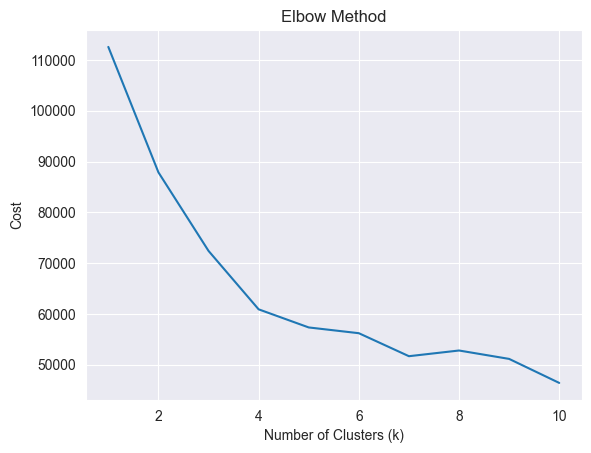

In [8]:
# Plot the cost against the number of clusters to identify the elbow
plt.plot(range(1,11), cost)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()

**<big>ii) The Silhouette method</big>**

In [9]:
#Encoding the data
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded = df.copy()
df_encoded['item_name'] = label_encoder.fit_transform(df_encoded['item_name'])
df_encoded['category_name'] = label_encoder.fit_transform(df_encoded['category_name'])

In [10]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):  #range 2 to 10 
    k_proto = KPrototypes(n_clusters = k, init='Cao', max_iter=50, n_jobs=-1, verbose=0)
    clusters = k_proto.fit_predict(df_encoded.values, categorical=[0, 1])
    silhouette_scores.append(silhouette_score(df_encoded.values, clusters))

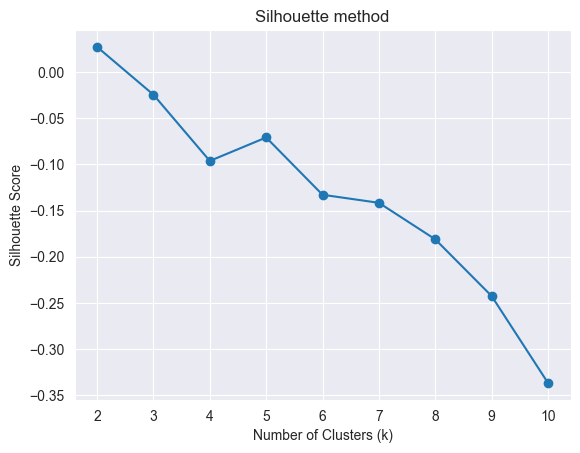

In [11]:
# Plot the silhouette scores against the number of clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette method')
plt.show()

**Modelling and viewing the clusters**
The elbow method did not display a clear elbow point,  but the silhouette method showed a proper peak at 6. Based on these results, the optimal number of clusters could  be  taken as six.

In [12]:
model = KPrototypes(n_clusters = 6, init='Cao', max_iter=50, n_jobs=-1, verbose=0)
predictions = model.fit_predict(df, categorical = [0,1])

In [13]:
#Creating a column called clusters in the main dataset
df['cluster'] = predictions

In [14]:
df.head()

,item_name,category_name,quantity_sold_kg,cluster
0,green hot peppers,capsicum,1.1,2
1,green hot peppers,capsicum,0.6,1
2,yunnan lettuces,flower,0.5,4
3,xixia mushroom,mushroom,0.4,5
4,paopaojiao,capsicum,0.6,1


In [15]:
x_values = [0,1,2,3,4,5]
y_values = []

for i in x_values:
    y_values.append(len(df[df['cluster']==i]))

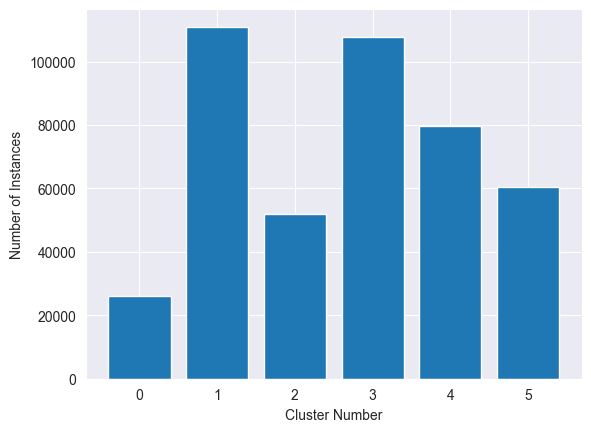

In [16]:
plt.bar(x_values,y_values)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Instances")
plt.show()

In [17]:
df_encoded['cluster'] = df['cluster']
df_encoded

,item_name,category_name,quantity_sold_kg,cluster
0,40,2,1.1,2
1,40,2,0.6,1
2,144,3,0.5,4
3,136,4,0.4,5
4,83,2,0.6,1
...,...,...,...,...
437053,124,3,1.0,2
437054,124,3,1.0,2
437055,143,3,1.0,2
437056,124,3,1.0,2


In [18]:
#Scatter Plot requires encoded categorical data
c1 = df_encoded[df_encoded['cluster']==0] #Rows that were assigned to the cluster 0
c2 = df_encoded[df_encoded['cluster']==1] #Rows that were assigned to the cluster 1
c3 = df_encoded[df_encoded['cluster']==2] #Rows that were assigned to the cluster 2
c4 = df_encoded[df_encoded['cluster']==3]
c5 = df_encoded[df_encoded['cluster']==4]
c6 = df_encoded[df_encoded['cluster']==5]

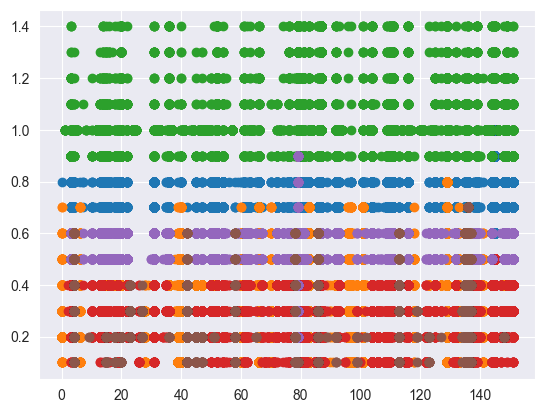

In [19]:
#Only for two features
plt.scatter(c1['item_name'], c1['quantity_sold_kg'])
plt.scatter(c2['item_name'], c2['quantity_sold_kg'])
plt.scatter(c3['item_name'], c3['quantity_sold_kg'])
plt.scatter(c4['item_name'], c4['quantity_sold_kg'])
plt.scatter(c5['item_name'], c5['quantity_sold_kg'])
plt.scatter(c6['item_name'], c6['quantity_sold_kg'])

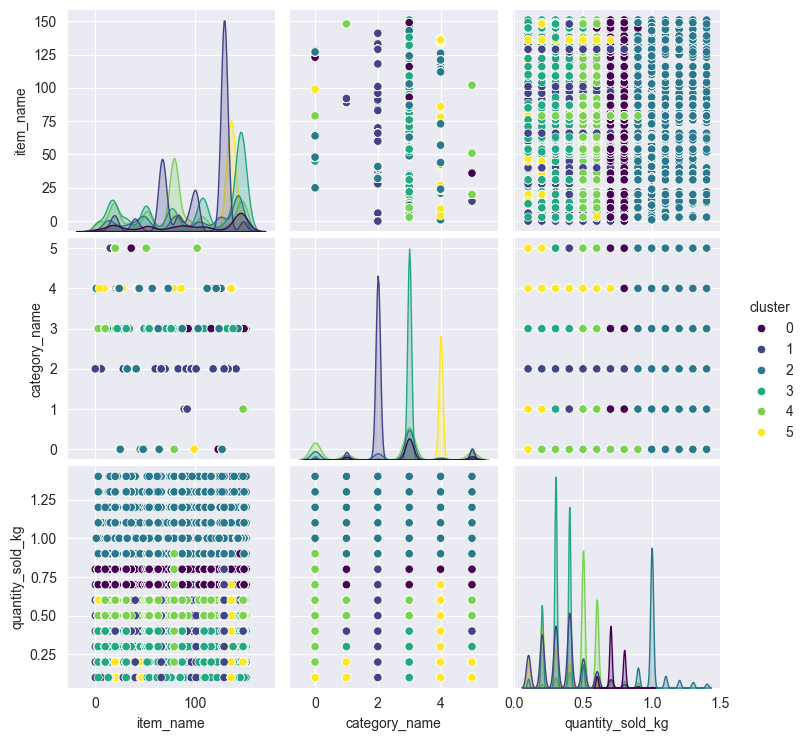

In [20]:
import seaborn as sns
df_encoded['cluster'] = model.labels_
sns.pairplot(df_encoded, hue='cluster', palette='viridis')
plt.show()

In [21]:
#A second model with kmeans
df_encoded2 = df_encoded.drop('cluster', axis=1)
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = 6, init = 'k-means++' , random_state = 42, verbose=0)
predictions2 = model2.fit_predict(df_encoded2)

df_encoded2['cluster'] = predictions2

In [22]:
y_values2 = []

for i in x_values:
    y_values2.append(len(df_encoded2[df_encoded2['cluster']==i]))

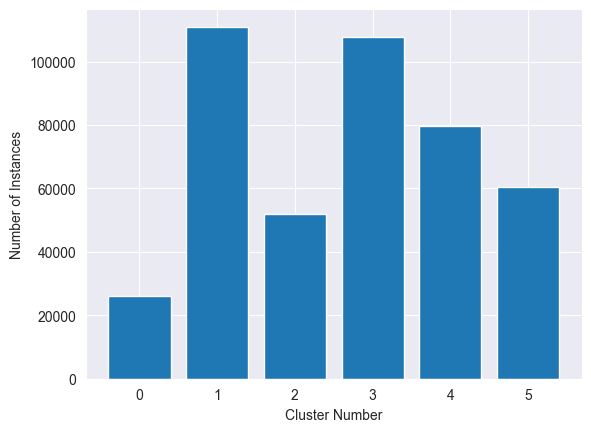

In [23]:
plt.bar(x_values,y_values)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Instances")
plt.show()

In [24]:
from sklearn.metrics import silhouette_score
kproto = KPrototypes(n_clusters=6, init='Cao', max_iter=50, n_jobs=-1, verbose=0)
labels_kproto = kproto.fit_predict(df_encoded2, categorical=[0,1])
silhouette_kproto = silhouette_score(df_encoded2.values, labels_kproto)


kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42,  verbose=0)
labels_kmeans = kmeans.fit_predict(df_encoded2)
silhouette_kmeans = silhouette_score(df_encoded2, labels_kmeans)

print(f"Silhouette Score (K-Prototypes): {silhouette_kproto}")
print(f"Silhouette Score (K-Means): {silhouette_kmeans}")

Silhouette Score (K-Prototypes): 0.6832218591830412
Silhouette Score (K-Means): 0.6820781185392669


In [25]:
#Saving the model
import pickle
with open('../models/cluster_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [26]:
#Loading the model
with open('../models/cluster_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [27]:
import numpy as np
new_purchase = ['shanghaiqing', 'flower', 0.9]
new_purchase_array = np.array([new_purchase])

In [28]:
predicted_cluster = loaded_model.predict(new_purchase_array, categorical=[0, 1])

In [29]:
predicted_cluster

array([2], dtype=uint16)

In [30]:
def pred(iName,cName,qSold):
    purchase = [iName, cName, qSold]
    purchase_array = np.array([purchase])
    pred_cluster = loaded_model.predict(purchase_array, categorical=[0, 1])
    return pred_cluster

pred('shanghaiqing', 'flower', 0.9)    

array([2], dtype=uint16)

In [31]:
discount_frac = {0:0.25, 1:0.05, 2:0.15, 3:0.35, 4:0.5, 5:0.1}

def offer(iName,cName,qSold):
    purchase = [iName, cName, qSold]
    purchase_array = np.array([purchase])
    pred_cluster = loaded_model.predict(purchase_array, categorical=[0, 1])
    discount = discount_frac.get(int(pred_cluster))
    discount_qsold = qSold*(1-discount)
    print("You are charged only for ",discount_qsold)   
    
offer('shanghaiqing', 'flower', 0.9)    

You are charged only for  0.765


/var/folders/p1/plqqz3vn75d873bd3kj4mtgw0000gn/T/ipykernel_2931/1316255688.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  discount = discount_frac.get(int(pred_cluster))


In [32]:
def discount(iName, cName, qSold):
    purchase = [iName, cName, qSold]
    purchase_array = np.array([purchase])
    pred_cluster = loaded_model.predict(purchase_array, categorical=[0, 1])
    
    count = 0
    discount_item_names = []

    while count < 10:
        random_item_name = np.random.choice(df['item_name'])
        if (df[df['item_name'] == random_item_name]['cluster'].values[0] != pred_cluster) and (random_item_name not in discount_item_names):
            count += 1
            discount_item_names.append(random_item_name)
    
    for i in range(len(discount_item_names)):
        print(discount_item_names[i], df[df['item_name'] == discount_item_names[i]]['cluster'].values[0])
    
    return discount_item_names

In [33]:
discount('shanghaiqing', 'flower', 0.9)

needle mushroom 5
yunnan lettuces 4
xixia xianggu mushroom 5
wuhu green pepper 1
amaranth 4
yunnan shengcai 0
zhuyecai 3
zhijiang qinggengsanhua 0
caixin 4
lameizi 1


['needle mushroom',
 'yunnan lettuces',
 'xixia xianggu mushroom',
 'wuhu green pepper',
 'amaranth',
 'yunnan shengcai',
 'zhuyecai',
 'zhijiang qinggengsanhua',
 'caixin',
 'lameizi']

In [34]:
discount('shanghaiqing', 'flower', 0.9)

shanghaiqing 4
yellow xincai 4
zhuyecai 3
qinggengsanhua 1
xixia mushroom 5
luosi pepper 1
wuhu green pepper 1
yunnan lettuces 4
red hot peppers 1
spinach 3


['shanghaiqing',
 'yellow xincai',
 'zhuyecai',
 'qinggengsanhua',
 'xixia mushroom',
 'luosi pepper',
 'wuhu green pepper',
 'yunnan lettuces',
 'red hot peppers',
 'spinach']

In [35]:
df.to_csv('../datasets/model_building.csv', index=False)